In [1]:
%load_ext autoreload
%autoreload 2

from train import *
from models import *
from tools import *

from keras import optimizers
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import display

import numpy as np
import os

Using TensorFlow backend.


In [2]:
X_train, y_train = load_data()
X_val, y_val = load_data("val")
X_test, _ = load_data("test")

input_shape = X_train[0].shape
print("Input shape: " + str(input_shape))
print(X_train[0][0][0])

y_train = to_categorical(y_train, 200)
y_val = to_categorical(y_val, 200)

Loading train data

Finished loading train data

Loading val data

Finished loading val data

Loading test data

Finished loading test data

Input shape: (64, 64, 3)
[0.75294118 0.83137255 0.83529412]


In [3]:
labels = get_label_dict()
words = get_word_labels()

test_images = os.listdir("data/tiny-imagenet-200/test/images/")
assert len(X_test) == len(test_images)

Loading labels

Done

Loading words

Done



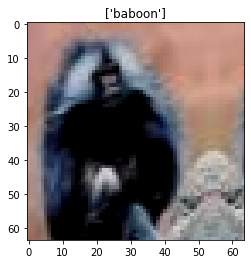

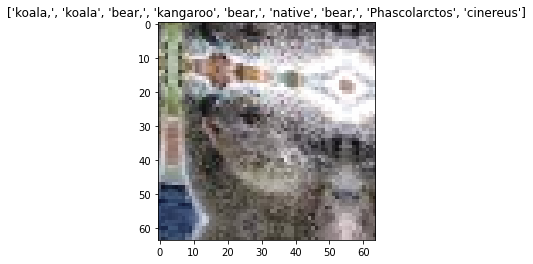

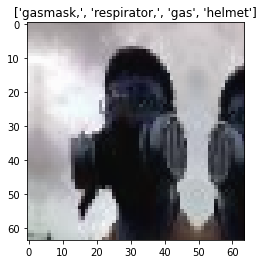

In [44]:
# Image preprocessing for the data
datagen = ImageDataGenerator(horizontal_flip=True, 
                             shear_range=20., 
                             zoom_range=0.5, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             channel_shift_range=0.1, 
                             fill_mode="reflect", 
                             preprocessing_function=shuffle_channels)

# Sample preprocessed images
for sample, label in datagen.flow(X_train, y_train, batch_size=3):
    for i in range(3):
        plt.plot()
        plt.title(words[labels[np.argmax(label[i])]])
        plt.imshow(sample[i])
        plt.show()
    break

testgen = ImageDataGenerator()

data = {"train": (X_train, y_train), 
        "val": (X_val, y_val)}

In [45]:
keras.backend.clear_session()

model = BravoNet(input_shape, "v2")
model_prefix = "models/" + model.name + "/" + model.name
model_path = model_prefix + ".h5"

Model: "resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 64, 64, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 64)   9408        zero_padding2d_1[0][0]           
___________________________________________________________________________________________

Model: "BravoNet_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet18 (Model)             (None, 2, 2, 512)         11186889  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               102600    
Total params: 11,289,489
Trainable params: 11,281,547
Non-trainable params: 7,942
_________________________________________________________________


In [46]:
# Saves the best model based on monitor value between epochs
checkpoint = ModelCheckpoint(model_path, 
                             monitor="val_accuracy", 
                             verbose=1, 
                             save_best_only=True, 
                             period=1)

# Stops training early when no improvement for monitor value
early_stop = EarlyStopping(monitor="val_accuracy", 
                           min_delta=0, 
                           patience=10, 
                           verbose=1)

# Reduces learning rate when monitor value plateaus
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", 
                              factor=0.316, 
                              patience=5, 
                              verbose=1)

# Logs training data to CSV
restore = False # Whether or not we want to restore weights and continue training from a previous session
csv_log = CSVLogger(model_prefix + ".csv", separator=',', append=restore)

cb_list = [checkpoint, early_stop, reduce_lr, csv_log]

In [47]:
optim = optimizers.Adam(learning_rate=0.001)

history = train(model_path=model_path, 
                restore=restore, 
                epochs=300,
                model=model, 
                optim=optim,
                datagen=datagen, 
                testgen=testgen, 
                data=data, 
                cb_list=cb_list, 
                batch_size=32)

Epoch 1/300
 - 495s - loss: 4.9534 - accuracy: 0.0315 - top3_accuracy: 0.0775 - top5_accuracy: 0.1153 - val_loss: 4.0461 - val_accuracy: 0.0774 - val_top3_accuracy: 0.1727 - val_top5_accuracy: 0.2348

Epoch 00001: val_accuracy improved from -inf to 0.07740, saving model to models/BravoNet_v2/BravoNet_v2.h5
Epoch 2/300
 - 484s - loss: 4.4456 - accuracy: 0.0790 - top3_accuracy: 0.1693 - top5_accuracy: 0.2360 - val_loss: 4.3904 - val_accuracy: 0.1273 - val_top3_accuracy: 0.2570 - val_top5_accuracy: 0.3429

Epoch 00002: val_accuracy improved from 0.07740 to 0.12730, saving model to models/BravoNet_v2/BravoNet_v2.h5
Epoch 3/300
 - 501s - loss: 4.1375 - accuracy: 0.1179 - top3_accuracy: 0.2369 - top5_accuracy: 0.3128 - val_loss: 3.7156 - val_accuracy: 0.1476 - val_top3_accuracy: 0.2908 - val_top5_accuracy: 0.3821

Epoch 00003: val_accuracy improved from 0.12730 to 0.14760, saving model to models/BravoNet_v2/BravoNet_v2.h5
Epoch 4/300
 - 476s - loss: 3.9183 - accuracy: 0.1499 - top3_accuracy:

InternalError: GPU sync failed

In [ ]:
show_history(history)

In [ ]:
# This loads the model and makes predictions on the test set
custom_metrics = {
    "top3_accuracy": top3_acc,
    "top5_accuracy": top5_acc
}
model = load_model(model_path, custom_objects=custom_metrics)
output = model.predict(X_test)
results = []

for result in output:
    results.append(labels[np.argmax(result)])
    
assert len(results) == len(X_test)
print("Test images predicted:", len(results))

In [ ]:
# This writes the test set predictions to file
with open(model_prefix + " Predictions.txt", "w") as test_file:
    for i in range(len(results)):
        test_file.write(test_images[i] + " " + results[i] + "\n")
    print("Predictions saved at", test_file.name)

In [ ]:
# This shows some test set images and the model's predictions on them
display_dim = 128
for _ in range(10):
    index = np.random.randint(len(X_test))
    word_label = words[results[index]]
    plt.plot()
    plt.title(word_label)
    plt.imshow(X_test[index])
    plt.show()

In [ ]:
# This saves an HTML version of the notebook for later viewing
# NOTE: Make sure to check if the html was completely saved, sometimes it doesn't
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read("Training.ipynb", as_version=nbformat.NO_CONVERT)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(model_prefix + ".html", "w").write(output)